# Tweaking the Model

In [1]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator

import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
# can try doing addfiles to spark init in nb_spark - maybe terminal option for files
from src import EDA, ModelEvaluation, Preprocess, Split
%load_ext autoreload
%autoreload 2

spark_session = SparkSession.builder.getOrCreate()

In [2]:
steam_df = EDA.load_without_cold_start(min_games_played=5, min_users_for_game=3)
preprocessor = Preprocess.PandasALSPreprocessor(steam_df)
preprocessor.process_general()
preprocessor.process_buckets()
preprocessor.process_min_max()
preprocessor.keep_standard_columns()
steam_df = preprocessor.get_df()
steam_df.head(2)

/Users/michaelbarton/Code/gproject/src/EDA.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return filtered_users[steam_df['game_name'].isin(usable_games['game_name'].values)]
/Users/michaelbarton/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,uid,playtime,playtime_min_max,game_name,game_uid
1,151603712,273.0,0.412256,The Elder Scrolls V Skyrim,0
3,151603712,87.0,0.414122,Fallout 4,1


In [3]:
# need holdout users.  Hold out 10%.  We could put some percent of their games into
# the training but it will make it very complicated
pandas_train_test = Split.PandasTrainTest(steam_df, seed=1)
train_val, holdout_test = pandas_train_test.user_only_split(user_split_train=.9)
print('split sizes: ', (train_val.shape[0], holdout_test.shape[0]))

pandas_train_test = Split.PandasTrainTest(train_val, seed=1)
k_fold_dfs = pandas_train_test.get_k_folds(5, game_split_train=.3)
for i, d in enumerate(k_fold_dfs):
    printed = 'train test split size ' + str(i) + ': '
    print(printed, (d[0].shape[0], d[1].shape[0]))

split sizes:  (49854, 5213)
Number of users:  2192
train test split size 0:  (42661, 7129)
train test split size 1:  (43515, 6275)
train test split size 2:  (42998, 6792)
train test split size 3:  (42501, 7289)
train test split size 4:  (42067, 7723)


In [4]:
# Convert to spark
sparkified_k_fold_dfs = [(spark_session.createDataFrame(a), spark_session.createDataFrame(b)) for a, b in k_fold_dfs]

In [6]:
als_models = [ALS(
    itemCol='game_uid',
    userCol='uid',
    ratingCol='playtime_min_max',
    nonnegative=True,    
    regParam=0.1,
    coldStartStrategy="drop", # Drops if user or item in test was not in train
    rank=i
) for i in range(1, 100)]

In [7]:
mean_rmses = []
for als_model in als_models[:11]:
    rmses = []
    for train, test in sparkified_k_fold_dfs:
        fitted_als_model = als_model.fit(train)
        predictions = fitted_als_model.transform(test)
        evaluator = RegressionEvaluator() \
            .setMetricName("rmse") \
            .setLabelCol("playtime_min_max") \
            .setPredictionCol("prediction")
        rmse = evaluator.evaluate(predictions)
        rmses.append(rmse)
    mean_rmse = sum(rmses) / len(rmses)
    print('rmse: {}'.format(mean_rmse))
    mean_rmses.append(mean_rmse)

rmse: 0.6950887698192904
rmse: 0.6970252361930702
rmse: 0.698893931829734
rmse: 0.6940727429391034
rmse: 0.6905435715170509
rmse: 0.6890981243456585
rmse: 0.6868152363101588
rmse: 0.6835677669531479
rmse: 0.6848170447160001
rmse: 0.6863318385234651
rmse: 0.6826298651650528


In [9]:
mean_rmses2 = []
# shoulda done 0:10 for first
for als_model in als_models[11:21]:
    rmses = []
    for train, test in sparkified_k_fold_dfs:
        fitted_als_model = als_model.fit(train)
        predictions = fitted_als_model.transform(test)
        evaluator = RegressionEvaluator() \
            .setMetricName("rmse") \
            .setLabelCol("playtime_min_max") \
            .setPredictionCol("prediction")
        rmse = evaluator.evaluate(predictions)
        rmses.append(rmse)
    mean_rmse = sum(rmses) / len(rmses)
    print('rmse: {}'.format(mean_rmse))
    mean_rmses2.append(mean_rmse)

rmse: 0.6829671060195952
rmse: 0.6819593198397017
rmse: 0.6781553274795546
rmse: 0.6774872398675311
rmse: 0.6789165435054688
rmse: 0.6788463190278659
rmse: 0.6769692908079634
rmse: 0.6771703567633454
rmse: 0.677417898154309
rmse: 0.676713354481069


/Users/michaelbarton/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


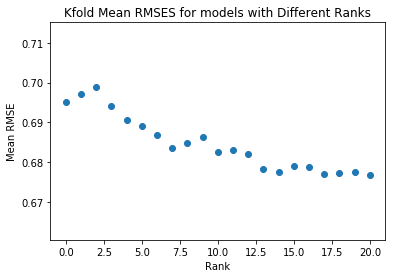

In [10]:
fig, ax = plt.subplots()
ax.scatter(list(range(0,21)), mean_rmses + mean_rmses2)
ax.set_title('Kfold Mean RMSES for models with Different Ranks')
ax.set_xlabel('Rank')
ax.set_ylabel('Mean RMSE')
fig.show()
fig.savefig('../figures/rank_rmse_decreasing.png')

In [35]:
mean_rmses3 = []
# shoulda done 0:10 for first
for als_model in als_rank_models[21:31]:
    rmses = []
    for train, test in sparkified_k_fold_dfs:
        fitted_als_model = als_model.fit(train)
        predictions = fitted_als_model.transform(test)
        evaluator = RegressionEvaluator() \
            .setMetricName("rmse") \
            .setLabelCol("playtime_min_max") \
            .setPredictionCol("prediction")
        rmse = evaluator.evaluate(predictions)
        rmses.append(rmse)
    mean_rmse = sum(rmses) / len(rmses)
    mean_rmses3.append(mean_rmse)

/Users/michaelbarton/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


0.7345949071133352

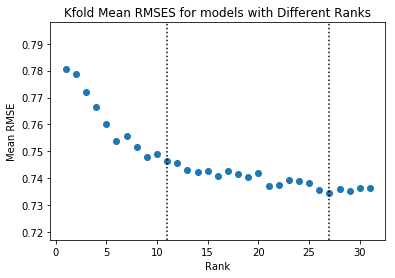

In [47]:
fig, ax = plt.subplots()
combined_rmses = mean_rmses + mean_rmses2 + mean_rmses3
ax.scatter(list(range(1,32)), combined_rmses)
ax.set_title('Kfold Mean RMSES for models with Different Ranks')
ax.set_xlabel('Rank')
ax.set_ylabel('Mean RMSE')
ax.axvline(11, color='black', linestyle=':')
ax.axvline(27, color='black', linestyle=':')
fig.show()
combined_rmses[26]

In [16]:
# we leave more than the top sorted by prediction because the actual may be n away from the 
# top predictions
def sort_predictions_slice(arr, n):
    actual_and_pred = np.array(arr)
    # sort by predictions
    indeces = np.argsort(actual_and_pred[:, 1])
    return actual_and_pred[indeces[::-1]][:n].tolist()

def dcg_at_k(scores, k):
    """
    Discounted cumulative gain
    See http://fastml.com/evaluating-recommender-systems/
    Args:
        r: List - Relevance scores in rank order
        k: Number of results to consider
    Returns:
        Float
    """
    r = np.asfarray(scores)[:k]
    if r.size:
        # item 1 and 2 have same weights
        # return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        # use below for more emphasis on first rank
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    print('sersly?')
    return 0.

def ndcg_at_k(scores, k):
    """
    Normalized Discounted cumulative gain
    See http://fastml.com/evaluating-recommender-systems/
    Args:
        r: List - Relevance scores in rank order
        k: Number of results to consider
    Returns:
        Float from 0 to 1
    """
    dcg_max = dcg_at_k(sorted(scores, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_at_k(scores, k) / dcg_max

def get_rdd_ndcg(rdd, top_n=3, label_col='playtime_min_max', prediction_col='prediction', id_col='uid'):
    rdd_ndcg = rdd.map(lambda row: (row[id_col], [(row[label_col], row[prediction_col])])) \
        .reduceByKey(lambda total, val: total + val) \
        .map(lambda kv: (kv[0], sort_predictions_slice(kv[1], 1000))) \
        .map(lambda kv: ndcg_at_k(np.array(kv[1])[:, 0], top_n)) \
        .sum()
    return rdd_ndcg

def fit_and_calculate_kfold_ndcg(model, train_test_dfs):
    results = []
    for train, test in train_test_dfs:
        fitted_model = model.fit(train)
        predictions = fitted_model.transform(test)
        predictions_rdd = predictions.rdd
        ndcg = get_rdd_ndcg(predictions_rdd, top_n=5, prediction_col='prediction')
        # can divide ndcg by user count - would be more efficient to pass counts
        num_users = len(predictions.groupby('uid').count().collect())
        results.append(ndcg / num_users)
    return sum(results) / len(results)

In [17]:
als_models = [ALS(
    itemCol='game_uid',
    userCol='uid',
    ratingCol='playtime_min_max',
    nonnegative=True,    
    regParam=0.1,
    coldStartStrategy="drop", # Drops if user or item in test was not in train
    rank=i
) for i in range(1, 101, 5)]
mean_ndcgs = []
for als_model in als_models[:3]:
    mean_ndcg = fit_and_calculate_kfold_ndcg(als_model, sparkified_k_fold_dfs)
    print('rank: {}, ndcg: {}'.format(als_model.getRank(), mean_ndcg))
    mean_ndcgs.append(mean_ndcg)

rank: 1, ndcg: 0.8259876377701477
rank: 2, ndcg: 0.821533715461902
rank: 3, ndcg: 0.8206144369044376


In [11]:
mean_ndcgs_test = []
for als_model in als_models[26:28]:
    mean_ndcg = fit_and_calculate_kfold_ndcg(als_model, sparkified_k_fold_dfs)
    print('rank: {}, ndcg: {}'.format(als_model.getRank(), mean_ndcg))
    mean_ndcgs_test.append(mean_ndcg)
    
# looks like it is just becoming more certain about the rankings... not changing anything

In [99]:
test_mod = als_models[0]
ttrain, ttest = sparkified_k_fold_dfs[0]
fitted_test_model = test_mod.fit(ttrain)
test_predictions = fitted_test_model.transform(ttest)
len(test_predictions.groupby('uid').count().collect())

438

In [12]:
fig, ax = plt.subplots()
ax.scatter(list(range(1,11)), mean_ndcgs)
ax.set_title('Kfold NDCG for models with Different Ranks')
ax.set_xlabel('Rank')
ax.set_ylabel('Mean NDCG')
fig.show()
# mean_rmses

In [15]:
mean_ndcgs2 = []
for als_model in als_models[10:20]:
    mean_ndcg = fit_and_calculate_kfold_ndcg(als_model, sparkified_k_fold_dfs)
    print('rank: {}, ndcg: {}'.format(als_model.getRank(), mean_ndcg))
    mean_ndcgs2.append(mean_ndcg)

11
rank: 11, ndcg: 0.03218711119679153
12
rank: 12, ndcg: 0.03177689593541009
13
rank: 13, ndcg: 0.032058995047159644
14
rank: 14, ndcg: 0.03221837975102719
15
rank: 15, ndcg: 0.03200839116979423
16
rank: 16, ndcg: 0.032659435392872985
17
rank: 17, ndcg: 0.03211225546781417
18
rank: 18, ndcg: 0.03173045352966628
19
rank: 19, ndcg: 0.03215484782017845
20
rank: 20, ndcg: 0.0322285678283997


/Users/michaelbarton/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


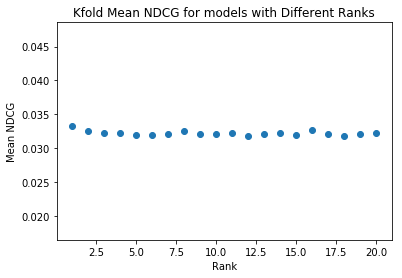

In [19]:
fig, ax = plt.subplots()
ax.scatter(list(range(1,21)), mean_ndcgs + mean_ndcgs2)
ax.set_title('Kfold Mean NDCG for models with Different Ranks')
ax.set_xlabel('Rank')
ax.set_ylabel('Mean NDCG')
fig.show()
# mean_rmses

In [17]:
mean_ndcgs3 = []
for als_model in als_models[20:30]:
    mean_ndcg = fit_and_calculate_kfold_ndcg(als_model, sparkified_k_fold_dfs)
    print('rank: {}, ndcg: {}'.format(als_model.getRank(), mean_ndcg))
    mean_ndcgs3.append(mean_ndcg)

rank: 21, ndcg: 0.03216954117170926
rank: 22, ndcg: 0.03239536669845905
rank: 23, ndcg: 0.03204883836663193
rank: 24, ndcg: 0.0320211984777437
rank: 25, ndcg: 0.031923914026656244
rank: 26, ndcg: 0.031973262301568335
rank: 27, ndcg: 0.03299763914757485
rank: 28, ndcg: 0.03260655299742274
rank: 29, ndcg: 0.03217291391158036
rank: 30, ndcg: 0.03222419605639058


In [20]:
mean_ndcgs4 = []
for als_model in als_models[30:40]:
    mean_ndcg = fit_and_calculate_kfold_ndcg(als_model, sparkified_k_fold_dfs)
    print('rank: {}, ndcg: {}'.format(als_model.getRank(), mean_ndcg))
    mean_ndcgs4.append(mean_ndcg)

rank: 31, ndcg: 0.03264524983692711
rank: 32, ndcg: 0.03251543088108967
rank: 33, ndcg: 0.03244909694715743
rank: 34, ndcg: 0.032149768646618136
rank: 35, ndcg: 0.03227262370049352
rank: 36, ndcg: 0.032493017365067926
rank: 37, ndcg: 0.03263978890530025
rank: 38, ndcg: 0.03228899511075565
rank: 39, ndcg: 0.03227304166459331
rank: 40, ndcg: 0.03211152470374258


In [84]:
def get_rdd_average_ndcg_2(rdd, top_n=3, label_col='playtime_min_max', prediction_col='prediction', id_col='uid'):
    count = rdd.count()
    ndcg = rdd.map(lambda row: (row[id_col], [(row[label_col], row[prediction_col])])) \
        .reduceByKey(lambda total, val: total + val) \
        .map(lambda kv: (kv[0], sort_predictions_slice(kv[1], 3))) \
        .map(lambda kv: ndcg_at_k(np.array(kv[1])[:, 0], top_n)) \
        .reduce(lambda total, gain: total + gain)
    average_ndcg = ndcg / count
    return average_ndcg

def test_alg(rdd, top_n=3, label_col='playtime_min_max', prediction_col='prediction', id_col='uid'):
    test = rdd.map(lambda row: (row[id_col], [(row[label_col], row[prediction_col])])) \
        .reduceByKey(lambda total, val: total + val) \
        .map(lambda kv: (kv[0], sort_predictions_slice(kv[1], 3))) \
        .map(lambda kv: ndcg_at_k(np.array(kv[1])[:, 0], top_n)) \
        .sum()
#         .reduce(lambda total, gain: total + gain)
    return test

def test_test(model, train_test_dfs):
    results = []
    for train, test in train_test_dfs:
        fitted_model = model.fit(train)
        predictions_rdd = fitted_model.transform(test).rdd
        # sampled = predictions_rdd.sample(False, 1, 1)
        test = test_alg(predictions_rdd, prediction_col='prediction')
        results.append(test)
    return results

def fit_and_calculate_kfold_ndcg_2(model, train_test_dfs):
    results = []
    for train, test in train_test_dfs:
        fitted_model = model.fit(train)
        predictions_rdd = fitted_model.transform(test).rdd
        # sampled = predictions_rdd.sample(False, 1, 1)
        average_ndcg = get_rdd_average_ndcg_2(predictions_rdd, prediction_col='prediction')
        results.append(average_ndcg)
    return sum(results) / len(results)

def ndcg_at_k(scores, k):
    """
    Normalized Discounted cumulative gain
    See http://fastml.com/evaluating-recommender-systems/
    Args:
        r: List - Relevance scores in rank order
        k: Number of results to consider
    Returns:
        Float from 0 to 1
    """
    dcg_max = dcg_at_k(sorted(scores, reverse=True), k)
    if not dcg_max:
        return 1.
    final = dcg_at_k(scores, k) / dcg_max
    if final < 0:
        print('ooooo')
    return final

In [85]:
als_models = [ALS(
    itemCol='game_uid',
    userCol='uid',
    ratingCol='playtime_min_max',
    nonnegative=True,    
    regParam=0.1,
    coldStartStrategy="drop", # Drops if user or item in test was not in train
    rank=i
) for i in range(1, 101)]
mean_ndcgs = []
for als_model in als_models[:1]:
    mean_ndcg = test_test(als_model, sparkified_k_fold_dfs)
    print('rank: {}, ndcg: {}'.format(als_model.getRank(), mean_ndcg))

7401
6679
7093
6968
8138
rank: 1, ndcg: [PythonRDD[13207] at RDD at PythonRDD.scala:48, PythonRDD[13208] at RDD at PythonRDD.scala:48, PythonRDD[13209] at RDD at PythonRDD.scala:48, PythonRDD[13210] at RDD at PythonRDD.scala:48, PythonRDD[13211] at RDD at PythonRDD.scala:48]


In [87]:
collected = mean_ndcg[0].collect()
ns = []
# for kv in get_100:
#     print(kv)
sum(collected)

416.56206904868384

### Max Iterations

In [4]:
als_model = ALS(
    itemCol='game_uid',
    userCol='uid',
    ratingCol='playtime_rank',
    nonnegative=True,    
    regParam=0.1,
    coldStartStrategy="drop", # Drops if user or item in test was not in train
    rank=10,
    maxIter=20,
) 

fitted_als_model = als_model.fit(train)

In [6]:
predictions = fitted_als_model.transform(test)

In [7]:
# predictions = fitted_als_model.transform(test)
evaluator = RegressionEvaluator() \
    .setMetricName("rmse") \
    .setLabelCol("playtime_rank") \
    .setPredictionCol("prediction")
rmse = evaluator.evaluate(predictions)
rmse
# 1.0051786784416223 with maxIter = 10..

1.0069301894654907

# No reg

In [6]:
als_models = [ALS(
    itemCol='game_uid',
    userCol='uid',
    ratingCol='playtime',
    nonnegative=True,    
    regParam=0.1,
    coldStartStrategy="drop", # Drops if user or item in test was not in train
    rank=i
) for i in range(1, 100)]

In [8]:
# this is already using all cores
mean_rmses = []
for als_model in als_models[:10]:
    rmses = []
    for train, test in sparkified_k_fold_dfs:
        fitted_als_model = als_model.fit(train)
        predictions = fitted_als_model.transform(test)
        evaluator = RegressionEvaluator() \
            .setMetricName("rmse") \
            .setLabelCol("playtime_min_max") \
            .setPredictionCol("prediction")
        rmse = evaluator.evaluate(predictions)
        rmses.append(rmse)
    mean_rmse = sum(rmses) / len(rmses)
    mean_rmses.append(mean_rmse)

In [10]:
sum(mean_rmses) / len(mean_rmses)

461.975980669396

In [11]:
mean_rmses

[442.70455082893966,
 701.21078942383,
 616.7765002619902,
 545.8536944885054,
 548.2485059854025,
 457.3473455728757,
 405.6827558159439,
 341.9442691354975,
 295.9830021694369,
 264.0083930115378]

In [19]:
als_models = [ALS(
    itemCol='game_uid',
    userCol='uid',
    ratingCol='playtime_min_max',
    nonnegative=True,    
    regParam=0.1,
    coldStartStrategy="drop", # Drops if user or item in test was not in train
    rank=10,
    maxIter=i
) for i in range(1, 101)]
mean_ndcgs = []
for als_model in als_models[:10]:
    mean_ndcg = fit_and_calculate_kfold_ndcg(als_model, sparkified_k_fold_dfs)
    print('rank: {}, ndcg: {}'.format(als_model.getRank(), mean_ndcg))
    mean_ndcgs.append(mean_ndcg)

rank: 10, ndcg: 0.8221150766608506
rank: 10, ndcg: 0.8225699453319308
rank: 10, ndcg: 0.8226940435114523
rank: 10, ndcg: 0.8213233517412105
rank: 10, ndcg: 0.8209206282969582
rank: 10, ndcg: 0.8212076336757239
rank: 10, ndcg: 0.8210023672984903


KeyboardInterrupt: 

In [ ]:
mean_ndcgs

In [23]:
steam_df = EDA.load_without_cold_start(min_games=10)
preprocessor = Preprocess.PandasALSPreprocessor(steam_df)
preprocessor.process_general()
preprocessor.process_buckets()
preprocessor.process_min_max()
preprocessor.keep_standard_columns()
steam_df = preprocessor.get_df()
steam_df.head(2)

/Users/michaelbarton/Code/gproject/src/EDA.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return filtered_users[steam_df['game_name'].isin(usable_games['game_name'].values)]
/Users/michaelbarton/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,uid,playtime,playtime_min_max,game_name,game_uid
1,151603712,273.0,1.412256,The Elder Scrolls V Skyrim,0
3,151603712,87.0,1.414122,Fallout 4,1


In [24]:
# need holdout users.  Hold out 10%.  We could put some percent of their games into
# the training but it will make it very complicated
pandas_train_test = Split.PandasTrainTest(steam_df, seed=1)
train_val, holdout_test = pandas_train_test.user_only_split(user_split_train=.9)
print('split sizes: ', (train_val.shape[0], holdout_test.shape[0]))

pandas_train_test = Split.PandasTrainTest(train_val, seed=1)
k_fold_dfs = pandas_train_test.get_k_folds(5, game_split_train=.3)
for i, d in enumerate(k_fold_dfs):
    printed = 'train test split size ' + str(i) + ': '
    print(printed, (d[0].shape[0], d[1].shape[0]))

split sizes:  (46232, 5301)
Number of users:  1330
train test split size 0:  (39147, 7085)
train test split size 1:  (39680, 6552)
train test split size 2:  (40106, 6126)
train test split size 3:  (39976, 6256)
train test split size 4:  (39660, 6572)


In [25]:
# Convert to spark
sparkified_k_fold_dfs = [(spark_session.createDataFrame(a), spark_session.createDataFrame(b)) for a, b in k_fold_dfs]

In [13]:
als_models = [ALS(
    itemCol='game_uid',
    userCol='uid',
    ratingCol='playtime_min_max',
    nonnegative=True,    
    regParam=0.1,
    coldStartStrategy="drop", # Drops if user or item in test was not in train
    rank=i,
) for i in range(1, 101)]
mean_ndcgs = []
for als_model in als_models[:10]:
    mean_ndcg = fit_and_calculate_kfold_ndcg(als_model, sparkified_k_fold_dfs)
    print('rank: {}, ndcg: {}'.format(als_model.getRank(), mean_ndcg))
    mean_ndcgs.append(mean_ndcg)

In [27]:
als_models = [ALS(
    itemCol='game_uid',
    userCol='uid',
    ratingCol='playtime_min_max',
    nonnegative=True,    
    regParam=0.1,
    coldStartStrategy="drop", # Drops if user or item in test was not in train
    rank=i,
) for i in range(1, 101)]
mean_ndcgs = []
for als_model in als_models[23:25]:
    mean_ndcg = fit_and_calculate_kfold_ndcg(als_model, sparkified_k_fold_dfs)
    print('rank: {}, ndcg: {}'.format(als_model.getRank(), mean_ndcg))
    mean_ndcgs.append(mean_ndcg)

rank: 24, ndcg: 0.7286111081591814
rank: 25, ndcg: 0.7313643299279526


In [41]:
# do a manual run for 25 and make sure its the same.